In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from monai.losses import DiceLoss
from monai.metrics import DiceMetric, compute_meandice
from monai.networks.nets import UNet
import torch
import torch.nn as nn
import numpy as np
import os
import torch.optim as opt
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.tensorboard import SummaryWriter
from tqdm.notebook import tqdm
import cv2
import h5py
from scipy.ndimage.interpolation import zoom
import torchvision.transforms as T
import random
import SimpleITK as sitk
import pandas as pd

In [2]:
info = pd.read_csv('./labeling.csv')
ct_paths = info.ct
gt_paths = info.reference
info['id'] = info.idx.apply(lambda x: x.split('/')[-1].split('.')[-3])
info.head()

,idx,ct,full,con,reference,id
0,1.2.840.113704.1.111.5860.1109410460.10.,./data/scans/1.2.840.113704.1.111.5860.1109410...,NaN,./data/consensusAnnotations/1.2.840.113704.1.1...,./data/referenceAnnotations/1.2.840.113704.1.1...,1109410460
1,1.2.840.113704.1.111.7092.1087039130.7.,./data/scans/1.2.840.113704.1.111.7092.1087039...,NaN,./data/consensusAnnotations/1.2.840.113704.1.1...,./data/referenceAnnotations/1.2.840.113704.1.1...,1087039130
2,1.2.840.113704.1.111.4276.1178184813.7.,./data/scans/1.2.840.113704.1.111.4276.1178184...,NaN,./data/consensusAnnotations/1.2.840.113704.1.1...,./data/referenceAnnotations/1.2.840.113704.1.1...,1178184813
3,1.2.840.113704.1.111.272.1131110755.7.,./data/scans/1.2.840.113704.1.111.272.11311107...,NaN,./data/consensusAnnotations/1.2.840.113704.1.1...,./data/referenceAnnotations/1.2.840.113704.1.1...,1131110755
4,1.2.840.113704.1.111.4348.1117273392.7.,./data/scans/1.2.840.113704.1.111.4348.1117273...,NaN,./data/consensusAnnotations/1.2.840.113704.1.1...,./data/referenceAnnotations/1.2.840.113704.1.1...,1117273392


In [3]:
example_ct = sitk.GetArrayFromImage(sitk.ReadImage(ct_paths[0], sitk.sitkFloat32))
example_gt = sitk.GetArrayFromImage(sitk.ReadImage(gt_paths[0], sitk.sitkInt8))
example_gt[example_gt > 0] = 1

In [4]:
example_ct.shape, example_gt.shape

((402, 318, 416), (402, 318, 416))

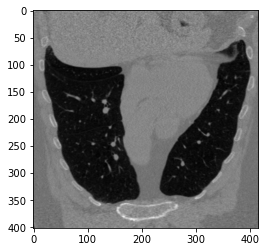

In [5]:
plt.imshow(example_ct[:, 100, :], cmap='gray')

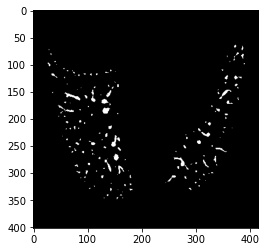

In [6]:
plt.imshow(example_gt[:, 100, :], cmap='gray')

In [7]:
np.unique(example_gt)

array([0, 1], dtype=int8)

In [8]:
train_idx = np.random.choice(range(45), 36, replace=False)

train_ct = ct_paths[[x for x in range(45) if x in train_idx]]
train_gt = gt_paths[[x for x in range(45) if x in train_idx]]

val_ct = ct_paths[[x for x in range(45) if x not in train_idx]]
val_gt = gt_paths[[x for x in range(45) if x not in train_idx]]

display(len(train_ct), len(train_gt), len(val_ct), len(val_gt))

36

36

9

9

In [ ]:
for ct_p, gt_p in tqdm(zip(train_ct, train_gt), total=len(train_gt)):
    ct = sitk.GetArrayFromImage(sitk.ReadImage(ct_p, sitk.sitkFloat32))
    gt = sitk.GetArrayFromImage(sitk.ReadImage(gt_p, sitk.sitkInt8))
    gt = zoom(gt, np.array([400, gt.shape[1], 400])/gt.shape)
    ct = zoom(ct, np.array(gt.shape)/np.array(ct.shape))
    print(gt.shape, ct.shape)
    gt[gt != 0] = 1
    print(np.unique(gt))
    ct = ct/np.mean(ct)
    for i in range(ct.shape[1]):
        hf = h5py.File('./train/{a}_{b}.h5'.format(a = ct_p.split('/')[-1].split('.')[-3], b = str(i)), 'w')
        hf.create_dataset('ct', data=ct[:, i, :])
        hf.create_dataset('gt', data=gt[:, i, :])

(400, 318, 400) (400, 318, 400)
[0 1]
(400, 326, 400) (400, 326, 400)
[0 1]


In [ ]:
for ct_p, gt_p in tqdm(zip(val_ct, val_gt), total=len(val_gt)):
    ct = sitk.GetArrayFromImage(sitk.ReadImage(ct_p, sitk.sitkFloat32))
    gt = sitk.GetArrayFromImage(sitk.ReadImage(gt_p, sitk.sitkInt8))
    gt = zoom(gt, np.array([400, gt.shape[1], 400])/gt.shape)
    ct = zoom(ct, np.array(gt.shape)/np.array(ct.shape))
    print(gt.shape, ct.shape)
    gt[gt != 0] = 1
    print(np.unique(gt))
    ct = ct/np.mean(ct)
    for i in range(ct.shape[1]):
        hf = h5py.File('./val/{a}_{b}.h5'.format(a = ct_p.split('/')[-1].split('.')[-3], b = str(i)), 'w')
        hf.create_dataset('ct', data=ct[:, i, :])
        hf.create_dataset('gt', data=gt[:, i, :])

In [12]:
val_gt = val_gt.tolist()
val_ct = val_ct.tolist()

In [19]:
ct = sitk.GetArrayFromImage(sitk.ReadImage(val_ct[4], sitk.sitkFloat32))
gt = sitk.GetArrayFromImage(sitk.ReadImage(val_gt[4], sitk.sitkInt8))
#gt = zoom(gt, np.array([400, gt.shape[1], 400])/gt.shape)
#ct = zoom(ct, np.array(gt.shape)/np.array(ct.shape))
#print(gt.shape, ct.shape)
#gt[gt != 0] = 1
#print(np.unique(gt))
#ct = ct/np.mean(ct)

In [23]:
len(os.listdir('./train')), len(os.listdir('./val'))

(11042, 2780)

In [12]:
for ct_p, gt_p in tqdm(zip(train_ct, train_gt), total=len(train_gt)):
    ct = sitk.GetArrayFromImage(sitk.ReadImage(ct_p, sitk.sitkFloat32))
    gt = sitk.GetArrayFromImage(sitk.ReadImage(gt_p, sitk.sitkInt8))
    gt[gt > 0] = 1
    print(np.mean(gt == 0))

0.9829897177453324
0.9864767852219465
0.9847080437830535
0.9782175363238034
0.9813107451082598
0.9759158694135402
0.9826722811886903
0.9845685067719915
0.9869026879562093
0.9819625681068155
0.9847623730595427
0.983781687151626
0.9845153068582919
0.9830365959333374
0.9830033925928819
0.9833756354665072
0.9842562855842849
0.9815655225721767
0.9836885799446503
0.982245185847719
0.9825168397025452
0.9848495889641358
0.9804589545792302
0.9845554400912007
0.9818515467718526
0.9869723313446642
0.9779466086871983
0.9848786559503647
0.9824704195643575
0.9813535829934344
0.9882410588839049
0.9819724049802663
0.9837390256698254
0.9831781135409169
0.9870380381836293
0.9840709229508312

